# Actividad evaluable del módulo 6: Redes generativas antagónicas convolucionales profundas (DCGAN)

En esta actividad, exploraremos la implementación de redes generativas antagónicas convolucionales profundas (DCGAN). Las GAN generaron un gran interés como aplicación de las redes neuronales profundas. Pytorch contiene código para implementar DCGAN, así como un tutorial. Para esta actividad, hemos adaptado el código disponible en el tutorial.

Para completar esta actividad, deberá entrenar redes de discriminación y generación para crear nuevas flores a partir del conjunto de datos de flores Oxford102flowers, disponible en Pytorch. Como aún no hemos mostrado ejemplos del proceso de entrenamiento de una GAN, el cuaderno incluye el código básico necesario.

Nota: entrenar estas GAN durante 100 ciclos requiere unos 15 minutos en un cuaderno de Colab si se utiliza una GPU.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización
image_size = 64
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

flowers_train = torchvision.datasets.Flowers102('', split = "train", transform =transform, download=True)

100%|██████████| 344862509/344862509 [00:13<00:00, 25998264.26it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 391728.49it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11841857.72it/s]


In [3]:
# Crearemos DataLoaders con un tamaño de lote de 102, lo que nos permitirá usar 10 lotes por ciclo
batch_size = 102
dataloaders = {'train': DataLoader(flowers_train, batch_size=batch_size)}

dataset_sizes = {'train': len(flowers_train)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1020}


## Visualización del conjunto de datos

Aquí, veremos una cuadrícula de muestra del conjunto de datos. Vemos que hay varias imágenes de cada flor.

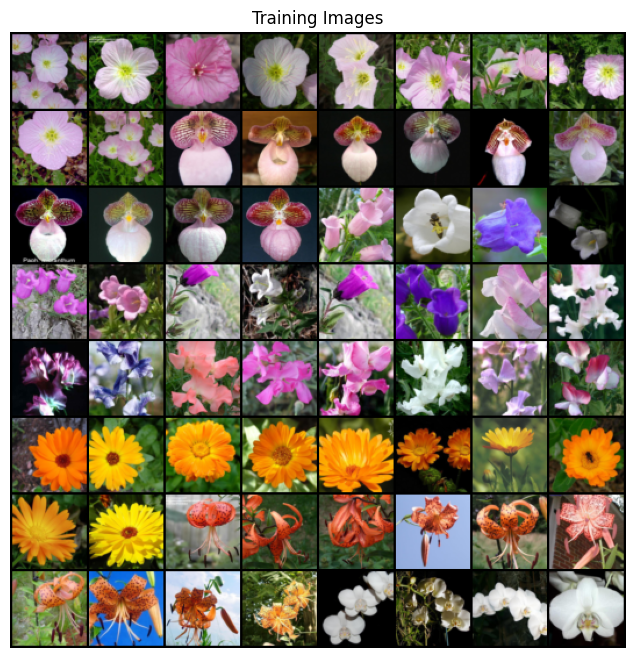

In [4]:
# Función de visualización extraída de: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Trazar algunas imágenes de entrenamiento
real_batch = next(iter(dataloaders["train"]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Creación de los modelos

Las redes de generación y discriminación son mucho más complejas que las CNN estándar. Más abajo, hemos definido algunos parámetros que aparecen en el artículo en el que se presentaron las GAN y en el tutorial de PyTorch.

In [5]:
# Número de canales de las imágenes de entrenamiento. Para las imágenes en color, es 3
nc = 3

# Tamaño del vector latente z (es decir, tamaño del input del generador)
nz = 100

# Tamaño de los mapas de atributos del generador
ngf = 64

# Tamaño de los mapas de atributos del discriminador
ndf = 64

In [16]:
# TAREA: Añada las funciones de activación a los modelos
# Debería añadir una LeakyRelu que opere con una pendiente negativa de 0,2
# para cada función de activación del discriminador, EXCEPTO la última,
# que debería ser sigmoide
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.pipeline = nn.Sequential(
            # El input es (nc) x 64 x 64

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            # TAREA: Función de activación
            nn.LeakyReLU(0.2, inplace=True),
            # Definir tamaño. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            # TAREA: Función de activación
            nn.LeakyReLU(0.2, inplace=True),
            # Definir tamaño. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            # TAREA: Función de activación
            nn.LeakyReLU(0.2, inplace=True),
            # Definir tamaño. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # TAREA: Función de activación
            nn.LeakyReLU(0.2, inplace=True),
            # Definir tamaño. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # TAREA: Función de activación
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.pipeline(input)

# Para el generador, utilizar funciones ReLU estándar que operen
# para todas las funciones de activación, excepto la última,
# que debería ser una TanH
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.pipeline = nn.Sequential(
            # El input es Z, con una convolución
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            # TAREA: Función de activación
            nn.ReLU(True),
            # Definir tamaño. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            # TAREA: Función de activación
            nn.ReLU(True),
            # Definir tamaño. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            # TAREA: Función de activación
            nn.ReLU(True),
            # Definir tamaño. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            # TAREA: Función de activación
            nn.ReLU(True),
            # Definir tamaño. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # TAREA: Función de activación
            nn.Tanh()
            # Definir tamaño. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.pipeline(input)

In [12]:
# Inicialización de pesos personalizados, llama a netg y netD
# Esta función inicializa los pesos de ciertas capas en función de las distribuciones descritas en el artículo original
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# TAREA: Crear el discriminador y el generador
netD = Discriminator(nc, ndf).to(device)
netG = Generator(nc, nz, ngf).to(device)

# Aplicar la función weights_init para inicializar de forma aleatoria todos los pesos
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)

# Imprimir el modelo
print(netD)
print(netG)

Discriminator(
  (pipeline): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generator(
  (pipeline): S

## Entrenamiento de los modelos

Este bucle de entrenamiento es muy diferente de los que hemos utilizado en el pasado. Está especializado en el entrenamiento de GAN. Entrenaremos con todo el conjunto, sin dejar imágenes de validación ni de prueba, ya que nos interesa mostrarle al modelo tantas imágenes como sea posible para mejorar sus habilidades de creación de imágenes.

In [23]:
# Entrenamiento adaptado de: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Establecer una convención sobre las eiquetas "real" y "falso" durante el entrenamiento
real_label = 1.
fake_label = 0.

# Crear un lote de vectores latentes que utilizaremos para visualizar
# la progresión del generador
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

def train_GANS(netD, netG, dataloaders, dataset_sizes, criterion, optimizerD, optimizerG, num_epochs=25):
    since = time.time()

    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    training_curves['G'] = []
    training_curves['D'] = []
    phase = 'train'

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for _, inputs in enumerate(dataloaders[phase], 0):

            ############################
            # (1) Actualizar la red D: maximizar log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Entrenar con un lote solo de imágenes reales
            optimizerD.zero_grad()
            # Formatear el lote
            real_cpu = inputs[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Hacer un forward pass del lote real a través de D
            output = netD(real_cpu).view(-1)
            # Calcular la pérdida con el lote real
            errD_real = criterion(output, label)
            # Calcular los gradientes de  D en la retropropagación
            errD_real.backward()
            D_x = output.mean().item()

            # Entrenar con un lote solo de imágenes falsas
            # Generar lote de vecores latentes
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generar lote de imágenes falsas con G
            fake = netG(noise)
            label.fill_(fake_label)
            # Clasificar el lote de imágenes falsas con D
            output = netD(fake.detach()).view(-1)
            # Calcular la pérdida de D con el lote falso
            errD_fake = criterion(output, label)
            # Calcular los gradientes de este lote, sumados a los anteriores
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Computar el error de D como una suma con los lotes de imágenes falsas y reales
            errD = errD_real + errD_fake
            # Actualizar D
            optimizerD.step()

            ############################
            # (2) Actualizar la red G: maximizar log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # Las etiquetas "falso" equivalen a "real" para el coste del generador
            # Como acabamos de actualizar D, realizamos otro forward pass del lote falso a través de D
            output = netD(fake).view(-1)
            # Calcular la pérdida de G a partir de este output
            errG = criterion(output, label)
            # Calcular los gradientes de G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Actualizar G
            optimizerG.step()

            training_curves['D'].append(errD.item())
            training_curves['G'].append(errG.item())

            print(f'D Loss: {errD.item():.4f}  G Loss: {errG.item():.4f}')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return netD, netG, training_curves


In [24]:
# Número de ciclos de entrenamiento
num_epochs = 100

# Tasa de aprendizaje para los optimizadores
lr = 0.0002

# Hiperparámetro Beta1 para los optimizadores Adam
beta1 = 0.5

# TAREA: Inicializar la función BCELoss
criterion = nn.BCELoss()

# Definir optimizadores Adam para G y D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Entrenar al modelo. También almacenaremos los resultados del entrenamiento para visualizarlo
netD, netG, training_curves = train_GANS(netD, netG, dataloaders, dataset_sizes,
                                     criterion, optimizerD, optimizerG, num_epochs=num_epochs)


Epoch 1/100
----------
D Loss: 2.1642  G Loss: 3.8108
D Loss: 1.9085  G Loss: 5.5364
D Loss: 1.3415  G Loss: 5.6857
D Loss: 0.9872  G Loss: 5.7930
D Loss: 0.7979  G Loss: 6.6467
D Loss: 0.6161  G Loss: 6.8771
D Loss: 0.7182  G Loss: 7.1275
D Loss: 0.5154  G Loss: 8.1856
D Loss: 0.6168  G Loss: 6.8555
D Loss: 1.0812  G Loss: 10.6623

Epoch 2/100
----------
D Loss: 0.5496  G Loss: 7.7744
D Loss: 1.6928  G Loss: 11.6452
D Loss: 0.8387  G Loss: 8.2127
D Loss: 1.2402  G Loss: 12.2712
D Loss: 0.2435  G Loss: 9.5171
D Loss: 1.2972  G Loss: 13.5892
D Loss: 0.5813  G Loss: 9.3306
D Loss: 1.2494  G Loss: 14.3225
D Loss: 0.5428  G Loss: 11.2680
D Loss: 0.5829  G Loss: 9.1771

Epoch 3/100
----------
D Loss: 1.7681  G Loss: 17.6682
D Loss: 0.9241  G Loss: 14.2878
D Loss: 0.7111  G Loss: 6.1253
D Loss: 5.6159  G Loss: 16.2999
D Loss: 1.1004  G Loss: 14.8912
D Loss: 0.3438  G Loss: 7.4107
D Loss: 3.4372  G Loss: 16.7881
D Loss: 0.9845  G Loss: 15.5345
D Loss: 0.6162  G Loss: 7.6758
D Loss: 2.5251  G

## Visualizar los resultados

Aquí podemos ver las curvas de entrenamiento de las dos redes y algunos ejemplos de las imágenes que ha creado el modelo generativo.

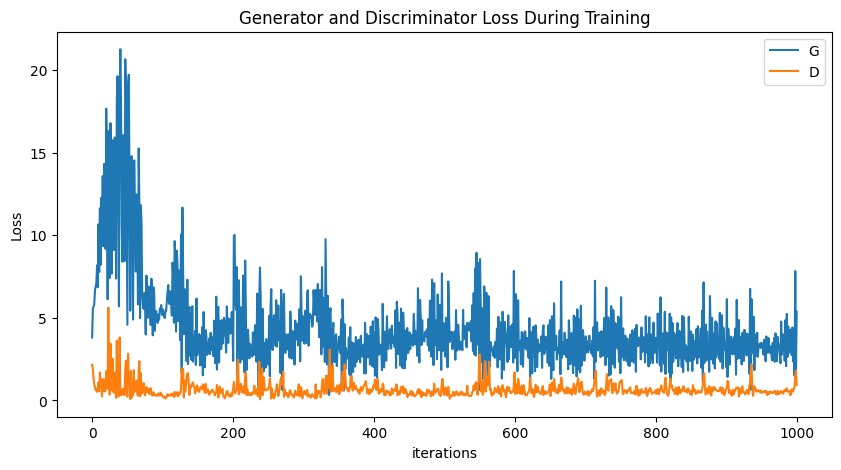

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(training_curves['G'] ,label="G")
plt.plot(training_curves['D'] ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

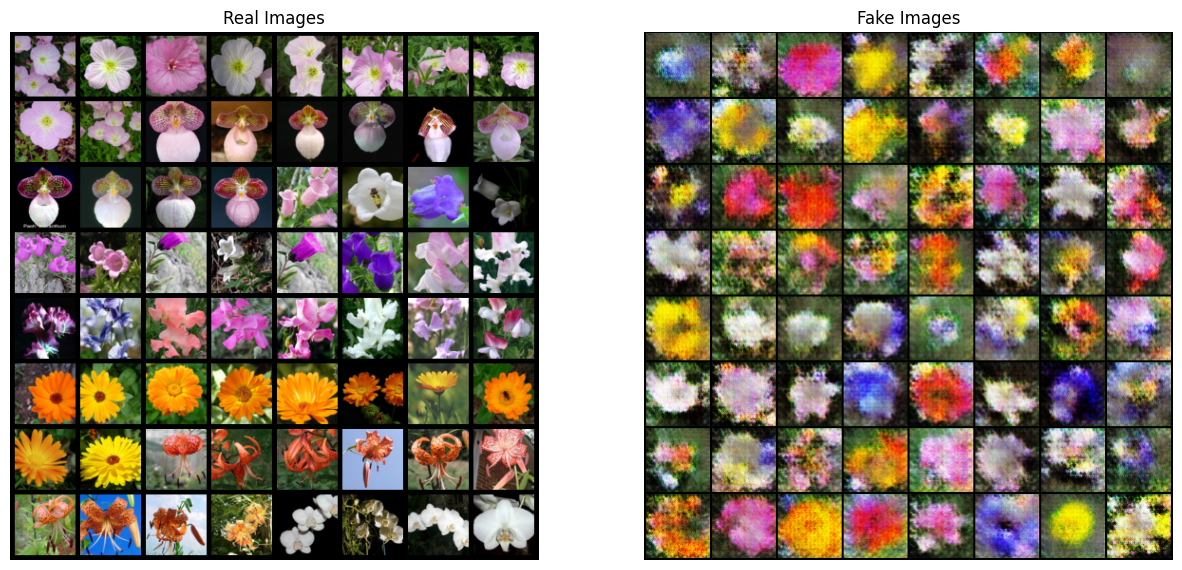

In [26]:
# Tomar un lote de imágenes reales del dataloader
real_batch = next(iter(dataloaders['train']))

# Trazar las imágenes reales
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generar imágenes falsas
img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Trazar las imágenes falsas del último ciclo
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Después de entrenar durante 100 ciclos, el modelo es capaz de generar imágenes de flores falsas que parecen más o menos convincentes. Pruebe a entrenarlo con otro conjunto de datos si quiere generar otro tipo de imágenes.